<a href="https://colab.research.google.com/github/IgorekFromRU/RecSys/blob/master/Recommender_Systems_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рекомендательные системы на основе глубокого обучения.

**Эмбеддинг** — пространство низкой размерности, которое отражает взаимосвязь векторов из пространства более высокой размерности.

 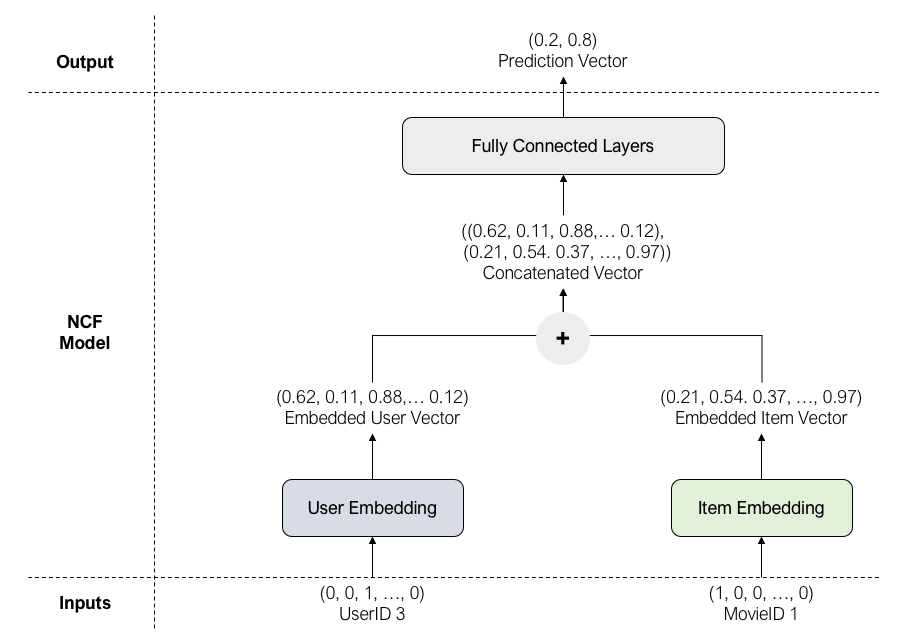

В качестве входных данных для нейронной сети мы передаём вектор характеристик пользователя и вектор для фильма (Inputs на схеме выше).

Из обоих этих векторов получаются эмбеддинги, о которых мы поговорили ранее (обозначены как Embedded User Vector и Embedded Item Vector). Далее эти эмбеддинги проходят через несколько полносвязных слоёв, на выходе из которых они преобразуются в вектор-предсказание. Например, на схеме выше видно, что вероятность первого класса (показывает, что элемент нерелевантен) — 0.2, а второго (показывает, что элемент релевантен) — 0.8. Следовательно, мы делаем выбор в пользу второго и рекомендуем этот продукт пользователю. Собственно, по такому алгоритму и обучается эта нейронная сеть.

Будем использовать модуль tensorflow, в котором реализовано много полезных методов для имплементации (внедрения) нейронных сетей.

In [ ]:
!pip install tensorflow

Импортируем из него функции, которые понадобятся нам для решения задачи:

In [3]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/DS/')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('data/ratings.csv')
df.head(3)

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5


## Задание 5.1

Разбейте данные на обучающую и тестовую выборки в отношении 4:1. В качестве значения параметра random_state возьмите число 42.

Сколько объектов теперь находится в обучающей выборке?

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
print(train.shape)

(785404, 3)


## Задание 5.2

Запишите количество уникальных книг в переменную n_books.

Сколько в наборе данных уникальных книг?

In [4]:
n_books = df.book_id.nunique()
print(f'{n_books=}')

n_books=10000


Задание 5.3

Запишите количество уникальных пользователей в переменную n_users.

Сколько в наборе данных уникальных пользователей?

In [5]:
n_users = df.user_id.nunique()
print(f'{n_users=}')

n_users=53424


Создаём эмбеддинги для книг:

In [12]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

Задаём размерность входного слоя. После этого определяем размер эмбеддинга — в данном случае снижаем размерность до 5. Далее мы разворачиваем результат в массив с одним измерением с помощью слоя Flatten().

Параметр shape=[1] в определении входного слоя (Input) указывает на форму входных данных для этого слоя. В данном случае, [1] означает, что входные данные представляют собой одномерный массив (вектор) с одним измерением.

Вторая пара скобок ((book_input)) является вызовом функции Embedding. Это необычный, но допустимый синтаксис Python, который позволяет вызывать функции сразу после их объявления.

Embedding(n_books+1, 5, name="Book-Embedding") - вызов конструктора класса Embedding, который создает слой встраивания. А (book_input) передается в этот конструктор в качестве аргумента, чтобы указать, что book_input будет использоваться в качестве входных данных для этого слоя.

Создаём эмбеддинги для пользователей:

In [13]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

Когда создали представления как для книг, так и для пользователей, необходимо соединить их:

In [14]:
conc = Concatenate()([book_vec, user_vec])

Начинаем «собирать» нашу нейронную сеть из слоёв. **Dense** обозначает полносвязный слой. Обозначим для него количество нейронов и данные, которые идут на вход.

In [15]:
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

Собираем модель — передаём входные данные для книг и пользователей, а также архитектуру нейронной сети:

In [16]:
model2 = Model([user_input, book_input], out)

Задаем алгоритм оптимизации - метод *adam* и метрику - *среднеквадратичную ошибку*:

In [17]:
model2.compile(optimizer = 'adam',loss =  'mean_squared_error')

Обучаем нашу модель:

In [18]:
history = model2.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)

Epoch 1/5
24544/24544 [==============================] - 201s 8ms/step - loss: 0.7987
Epoch 2/5
24544/24544 [==============================] - 188s 8ms/step - loss: 0.6885
Epoch 3/5
24544/24544 [==============================] - 183s 7ms/step - loss: 0.6620
Epoch 4/5
24544/24544 [==============================] - 186s 8ms/step - loss: 0.6380
Epoch 5/5
24544/24544 [==============================] - 174s 7ms/step - loss: 0.6154


В параметр эпох передаём значение 5: у нас будет реализовано пять эпох — пять обучений нейронной сети. На каждой из эпох обновляются веса для минимизации ошибки.

Теперь можно оценить качество:

In [ ]:
model2.evaluate([test.user_id, test.book_id], test.rating)

Подключаем в Colab ускоритель TPU.
Обычно для улучшения качества модели каким-то образом модифицируют нейронную сеть: дополняют её, увеличивают время обучения. Добавим ещё один полносвязный слой с восемью нейронами после полносвязного слоя с 32 нейронами. Обучим нейронную сеть, реализовав десять эпох:

In [9]:
# Импорт библиотеки
import tensorflow as tf

# Подключение TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

# Стратегия распределения
strategy = tf.distribute.TPUStrategy(resolver)

In [10]:
# Модель внутри стратегии
with strategy.scope():
    # Входные данные
    book_input = tf.keras.layers.Input(shape=[1], name="Book-Input")
    user_input = tf.keras.layers.Input(shape=[1], name="User-Input")

    # Встраивающие слои (embedding layers)
    book_embedding = tf.keras.layers.Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
    user_embedding = tf.keras.layers.Embedding(n_users+1, 5, name="User-Embedding")(user_input)

    # Преобразование вектора из слоев в одномерный вид
    book_vec = tf.keras.layers.Flatten(name="Flatten-Books")(book_embedding)
    user_vec = tf.keras.layers.Flatten(name="Flatten-Users")(user_embedding)

    # Объединение входных данных
    conc = tf.keras.layers.Concatenate()([user_vec, book_vec])

    # Последовательность слоев
    fc1 = tf.keras.layers.Dense(128, activation='relu')(conc)
    fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1)
    fc3 = tf.keras.layers.Dense(8, activation='relu')(fc2)
    out = tf.keras.layers.Dense(1)(fc3)

    # Модель
    model2 = tf.keras.models.Model([user_input, book_input], out)
    model2.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
result = model2.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)

# Оценка модели
model2.evaluate([test.user_id, test.book_id], test.rating)


Epoch 1/10
24544/24544 [==============================] - 444s 18ms/step - loss: 0.7998
Epoch 2/10
24544/24544 [==============================] - 406s 17ms/step - loss: 0.6889
Epoch 3/10
24544/24544 [==============================] - 404s 16ms/step - loss: 0.6601
Epoch 4/10
24544/24544 [==============================] - 419s 17ms/step - loss: 0.6355
Epoch 5/10
24544/24544 [==============================] - 413s 17ms/step - loss: 0.6157
Epoch 6/10
24544/24544 [==============================] - 432s 18ms/step - loss: 0.5959
Epoch 7/10
24544/24544 [==============================] - 416s 17ms/step - loss: 0.5770
Epoch 8/10
24544/24544 [==============================] - 419s 17ms/step - loss: 0.5595
Epoch 9/10
24544/24544 [==============================] - 410s 17ms/step - loss: 0.5438
Epoch 10/10
6136/6136 [==============================] - 68s 11ms/step - loss: 0.7431


0.7430917024612427

Качество получившейся модели не будет выше качества предыдущей, так как усложнение сети или увеличение количества эпох не всегда даёт высокое качество. Здесь главное, что вы научились корректировать архитектуру нейронной сети.